# Reverse engineering ngmix' gaussian moments - part 3

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import ngmix
import autometacal
import tensorflow as tf

Get a galaxy:

In [3]:
scale = .2
stamp_size=51
gal, psf = autometacal.data.galaxies.make_data(img_noise=0.000005,gal_g1=[0.2],gal_g2=[0.1],scale=scale)

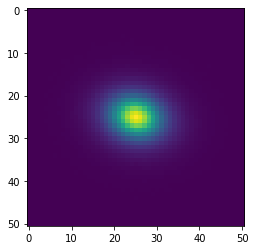

In [4]:
imshow(gal.numpy()[0])
obs=ngmix.Observation(gal.numpy()[0],jacobian=ngmix.DiagonalJacobian(row=25, col=25, scale=.2))

Set a fitter with Gaussian moments:

In [5]:
weight_fwhm = scale*stamp_size/2 # <- this sets everything for the window function
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
fitter._measure_moments(obs)

{'flags': 0,
 'npix': 2601,
 'wsum': 28.391886409860447,
 'sums': array([-1.40819422e-06, -7.50545493e-06,  8.63656546e-03,  4.36321380e-03,
         4.96443801e-02,  3.29991413e-02]),
 'sums_cov': array([[ 1.36575550e+00, -1.54954090e-18, -1.90131368e-16,
         -2.00238589e-17, -1.15060956e-17, -7.90294975e-18],
        [-2.41076165e-18,  1.36575550e+00, -2.89693738e-17,
         -5.68748743e-17, -8.08188016e-17, -1.94671994e-18],
        [-1.89264642e-16,  1.43853723e-17,  1.21351863e+01,
          2.98011602e-17,  4.72483448e-17,  2.22713847e-15],
        [-6.14268293e-18, -5.75253956e-17,  2.29164764e-17,
          1.26799874e+01, -3.73507648e-17, -3.52111596e-18],
        [-9.28348110e-18, -6.00800469e-17,  9.92976724e-17,
         -6.49979202e-17,  2.48151738e+01,  2.73151100e+00],
        [-7.90294975e-18, -1.94671994e-18,  2.22713847e-15,
         -3.52111596e-18,  2.73151100e+00,  5.88419538e-01]]),
 'pars': array([-4.26736624e-05, -2.27443947e-04,  2.61720915e-01,  1.32222

In [6]:
pix_weights = tf.ones([51,51])
jake=autometacal.tf_ngmix.make_diagonal_jacobian(25,25,scale=.2)
image = gal.numpy()[0]
pixels=autometacal.tf_ngmix.make_pixels(image,pix_weights,jake)
T = autometacal.tf_ngmix.fwhm_to_T(weight_fwhm)
weights = autometacal.tf_ngmix.create_gmix([0.,0.,0.,0.,T,1.],'gauss')
autometacal.tf_ngmix.get_moments(weights,pixels[tf.newaxis])

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0.17396869, 0.08788938]]], dtype=float32)>

## Testing

## Batch test

In [7]:
gals, psfs = autometacal.data.galaxies.make_data(Ngals=3,img_noise=0.000005,gal_g1=[0.2,0.1,0.0],gal_g2=[0.1,0.0,-0.1],scale=scale)

In [8]:
for gal in gals:
  obs=ngmix.Observation(gal,jacobian=ngmix.DiagonalJacobian(row=25, col=25, scale=.2))
  ngmix_res=fitter._measure_moments(obs)['e']
  print(ngmix_res)
  
  

[0.17396864 0.08788938]
[8.71905959e-02 9.12031781e-05]
[ 0.00024211 -0.08689829]


In [9]:
pixelss= tf.stack([autometacal.tf_ngmix.make_pixels(gal.numpy(),pix_weights,jake) for gal in gals],axis=0)

In [10]:
autometacal.tf_ngmix.get_moments(weights,pixelss)

<tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
array([[[ 1.7396869e-01,  8.7889381e-02],
        [ 8.7190576e-02,  9.1203947e-05],
        [ 2.4214992e-04, -8.6898290e-02]]], dtype=float32)>

In [11]:
from numpy.testing import assert_allclose

In [12]:
import time

In [13]:
#create galaxy image
scale = .2
stamp_size=51
Ngals = 100
gals, _ = autometacal.data.galaxies.make_data(Ngals=100, img_noise=0.0005,
                                               gal_g1=np.random.uniform(-.1,.1,100),
                                               gal_g2=np.random.uniform(-.1,.1,100),
                                               scale=scale)



In [14]:
obs_list=[]
for gal in gals:
  obs=ngmix.Observation(gal.numpy(),
                        jacobian=ngmix.DiagonalJacobian(row=25, 
                                                        col=25, 
                                                        scale=.2))
  obs_list.append(obs)

In [15]:
pixelss= tf.stack([autometacal.tf_ngmix.make_pixels(gal.numpy(),pix_weights,jake) for gal in gals],axis=0)

In [28]:
ti = time.time()
results_ngmix=[]
#ngmix version
for obs in obs_list:
  weight_fwhm = scale*stamp_size/2. 
  fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
  result_ngmix =fitter._measure_moments(obs)['e']
  results_ngmix.append(result_ngmix)
results_ngmix=np.array(results_ngmix)
print(time.time()-ti)

0.06485772132873535


In [29]:
ti = time.time()
#our version:
pix_weights = tf.ones([51,51])
#make jacobian
jake=autometacal.tf_ngmix.make_diagonal_jacobian(25,25,scale=.2)
#make pixels
T = autometacal.tf_ngmix.fwhm_to_T(weight_fwhm)
weights = autometacal.tf_ngmix.create_gmix([0.,0.,0.,0.,T,1.],'gauss')
result_tf_ngmix = autometacal.tf_ngmix.get_moments(weights,pixelss)
print(time.time()-ti)

0.015939950942993164


In [30]:
sum(abs(result_tf_ngmix - results_ngmix)/results_ngmix)

-0.00014789717

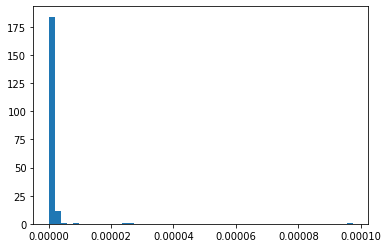

In [31]:
hist(((abs(result_tf_ngmix - results_ngmix)/abs(results_ngmix))).numpy().flatten(),bins=50);

In [38]:
51//2

25

In [27]:
assert_allclose(results_ngmix,result_tf_ngmix[0],rtol=1e-4)

In [35]:
teste=tf.stack([1,2,3])

In [37]:
teste

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [3] != values[1].shape = [] [Op:Pack]